# Practice 4

In this practice, we will expand on 1) How the DAS matrix , 2) how to combine different acquisitions to generate compound images and 3) work with convex probes and circular waves, that allow to better emmit in different directions and cover a larger area.

This practice needs more computational power. If you have problems, you can reduce the number of scatterers, the number of emmited waves (please, comment it in the report), or work with the updated version of the PyMUST code, so you can correctly use the option to parallelize the code and reduce the number of Fourier modes for which the backscattering is computed.

In [1]:
import pymust, matplotlib.pyplot as plt
import numpy as np, tqdm, tqdm.notebook

In [2]:
def polarplot(x, z, v, cmap = 'gray',background = 'black'):
    plt.pcolormesh(x, z, v, cmap = cmap)
    plt.axis('equal')
    ax = plt.gca()
    ax.set_facecolor(background)

def plotRF(RF, param, stride = 8):
    ts = np.arange(RF.shape[0]) /param.fs
    elementsToShow = np.arange(0, param.Nelements, stride)
    for i, idx in enumerate(elementsToShow):
        plt.plot(idx + stride/2*RF[:,idx]/np.max(np.abs(RF[:,idx])), ts *1e6, c = '#1f77b4')
    plt.ylabel('Time [$\mu$s]')
    plt.xlabel('Element #')
    plt.xlabel('Element #')


## Part 1: DAS Matrix

Image formation consists of the process in which we reconstruct an image from the radiofrequency. In MUST (and pyMUST), we use the delay-and-sum (DAS) matrix, which shares similarities to the algebraic reconstruction for CT reconstruction. Basically, it takes advantage of linearity and superposition of the echoes (assuming a linear propagation model): the recieved radiofrequencies of two scatterers is the individual sum of the radiofrequencies remmited by each scatterer. Under this hypothesis, from linear algebra we can deduce that the mapping that associates the recieved radiofrequency signals (multi-channel) and the image is a linear mapping, and therefore can be represented by a matrix. This matrix is the DAS matrix, and it is the one that we will use to reconstruct the image. To make the algebra work, since the image and radiofrequencies are 2D matrices, we need to reshape them into vectors (flatten instruction), and undo the reshape after the multiplication. This reshape needs to use the Fortran order (order = 'F'), to be consistent with the results of the reshape in the MATLAB code.

### A note on sparse matrices

The DAS matrix is sparse (i.e. most of its elements are 0s). This kind of matrices appear in many problems (for instance in finite elements / differences discretisations), and there has been a lot of work, both to mathematically understand them and also to provide numerical algorithms and structrues that take advantage of this sparsity. For instance, instead of of storing all the matrix, which would require storing $n^2$ floats, then we can store instead only the non-zero elements, which only requires $3s$ numbers, where $s$ is the number of non-zero elements (the $3$ comes from the fact that as well as the element value, we also need to store to which index and column it belongs). This is very useful, for instance, doing a matrix multipication usually requires the order of $n^2$ operations, where $n$ is the number of rows/columns of the matrix. However, if the matrix is sparse, we can take advantage of this to reduce the number of operations. 

In [4]:
data = np.load('scatters_p3.npz')
xs = data['xScatterers']
zs = data['zScatterers']
RC = data['RC']


Text(0.5, 1.0, 'Polar grid')

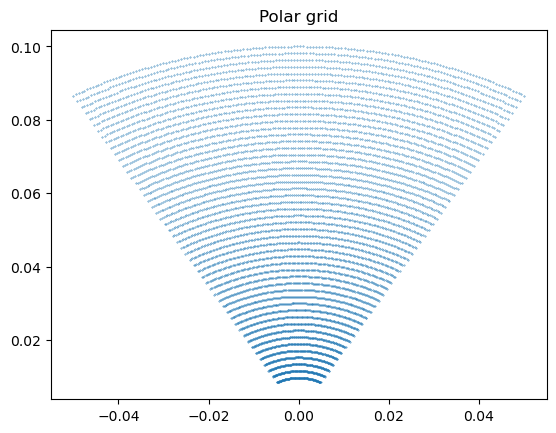

In [5]:
param = pymust.getparam('P4-2v')
xPixelGrid,zPixelGrid = pymust.impolgrid(np.array([50, 150], dtype = np.int64),10e-2,np.pi/3,param); # Generate a polar grid, with 10cm of maximum len gth, and covering the region from -pi/3 to pi/3 
plt.scatter(xPixelGrid.flatten(),zPixelGrid.flatten(), s = .1)
plt.title('Polar grid')

In [6]:
param.fs = param.fc * 4
param.c = 1540
dtMax = 0.05 * 2  /param.c # Travel time at the speed of sound for 10cm (including the time for going back )
nTimeSamples = int(dtMax * param.fs)
txdel = pymust.txdelayPlane(param, 0)
P, _, _ = pymust.pfield(xPixelGrid, [], zPixelGrid,txdel, param);
M = pymust.dasmtx(1j *np.array([nTimeSamples, param.Nelements]), xPixelGrid, zPixelGrid, txdel, param) # The first parameter indicates the size of the matrix. You can also give an IQ signal instead.

In [7]:
M_dense = M.todense() #Convert to a dense matrix .. takes some time

The pixel is at position 7.309641879862785e-05 0.02080089197448954


/Users/gbernardino/pymust/src/pymust/utils.py:249: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x, z, v, cmap = cmap)


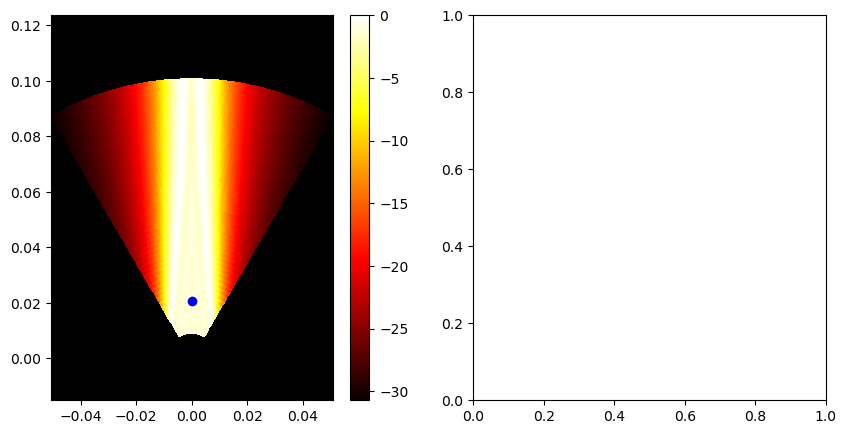

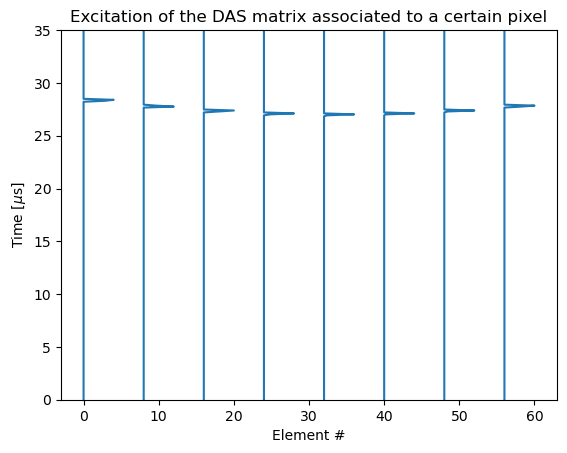

In [14]:

_, (f1, f2) = plt.subplots(ncols=2, figsize = (10, 5))
# Obtain the coordinates of the pixel
xFlatten = xPixelGrid.flatten(order = 'F')
zFlatten = zPixelGrid.flatten(order = 'F')

# Get a random row of the DAS matrix. Note 
ICol = np.argmin((xFlatten - 0)**2 + (zFlatten - 2e-2)**2 )


plt.sca(f1)
pymust.utils.polarplot(xPixelGrid, zPixelGrid, 20*np.log10(P/np.max(P)),
           cmap='hot') #We need to use this function to plot
plt.colorbar()


print('The pixel is at position', xFlatten[ICol], zFlatten[ICol])
plt.scatter(xFlatten[ICol], zFlatten[ICol], c = 'b')
if np.linalg.norm(M_dense[ICol, :]) < 1e-18:
    print('The pixel has a 0 row in the DAS matrix. Why?')
else:
    plt.sca(f2)
    plt.figure()
    # Extract the row of the Das matrix, and plot it as a RF signal
    plotRF(np.abs(M_dense[ICol, :]).reshape(nTimeSamples, param.Nelements, order = 'F'), param, stride = 8)
    plt.ylim(0, 35)
    plt.title('Excitation of the DAS matrix associated to a certain pixel')


***Exercise 4.1***
1. What are the dimensions of the DAS matrix, and why?
1. Find the pixel ID of the pixel closest to (0, 0.025)m, and plot the associated column of the DAS matrix as a RF signal. [See the snipplet below]
1. The DAS matrix column associated to some pixels (for instance, the one with linear array) is almost 0. Find one. Why is this? Hint: look at the pressure field.
1. Explain the relationship between the column of the DAS matrix associated to a certain pixel, and the radiofrequency signal that would be received if there was a scatterer in that pixel. Why is the DAS matrix sparse?
1. Do a simulation (simus) with a single scatterer at point (0, 0.025), and use the DAS matrix to reconstruct the image. Explain what you see. [Hint: rememeber to use the pymust.utils.polarplot if you want to usea polar pixel grid]. Remember that you learnt how to do a reconstruction using the DAS matrix.

Hint: To use the reconstruction using the DAS matrix, you can use the same  functions as in P3


In [1]:
x = 0.00
z = 0.05
distanceToPoint = (xPixelGrid.flatten(order = 'F') - x)**2 + (zPixelGrid.flatten(order = 'F') - z)**2
indexClosest = np.argmin(distanceToPoint)
indexClosest

NameError: name 'xPixelGrid' is not defined

## Part 2: Compound image

Unless the probe is very big, and the region of interest is small, a single acquisition does not provide enough field of view to the whole region of interest. What most ultrasound system do is to acquire several sequential acquisitions, and then fuse them together to produce a compound image. This is specially the case of cardiac ultrasound, where the probes are very small (to be able to fit in between the ribs), and there is a large region of interest (ROI).

Here, you will also use polar grids instead of rectangular grids. They allow a more approppriate representation of the ROI, when it is much larger than the probe, since the regions to the sides of the probe are never insonified. You can use the pymust functions impolgrid to generate a polargrid, and polarplot to display it.



In [ ]:
param = pymust.getparam('P4-2v')
xPixelGrid,zPixelGrid = pymust.impolgrid(np.array([100, 300], dtype = np.int64),10e-2,np.pi/3,param); # Generate a polar grid, with 10cm of maximum len gth, and covering the region from -pi/3 to pi/3 
plt.scatter(xPixelGrid.flatten(),zPixelGrid.flatten(), s = .1)
plt.title('Polar grid')

In [ ]:
N = 1
P =[None] * N

for i, tilt in enumerate(np.linspace(-np.pi/3,np.pi/3,N)):
    txdel = pymust.txdelayPlane(param, tilt)
    P[i], _, _ = pymust.pfield(xPixelGrid,[], zPixelGrid,txdel, param);
P = np.sum(P, axis = 0)
P_db = 20*np.log10(P/np.max(P))
pymust.utils.polarplot(xPixelGrid,zPixelGrid, P_db, cmap = 'hot',background = 'black') # You need to use polarplot instead of plt.imshow to display
plt.colorbar()


In [ ]:
np.l

***Exercise 4.2***
1. Load the parameters of a cardiac probe (P4-2v) and do a sectorial scan. Plot the sum of the pfields of several linear waves and determine the minimum number of acquisitions needed to cover the whole range  between $-\pi/3$ and $\pi/3$.
1. Repeat the same experiment, but by emmiting circular waves (pymust.txdelayCircular), with an opening angle of $pi/4$. Comment on the number of acquisitions needed, when compared .
1. Repeat the same experiment, but by emmiting linear waves with the convec probe (C5-2V). Comment on the number of acquisitions needed, when compared to the previous settings.

Hint: to load a probe, you need to use the pymust call "pymust.getparam" with the name of the probe as argument (for instance, "P4-2v").
Hint: you can consider that the space is fully covered when you can no longer observe the gaps between the different scan lienes.

In [ ]:
N = 1
RF =[None] * N
IQ =[None] * N
txdel =[None] * N

for i, tilt in tqdm.notebook.tqdm(enumerate(np.linspace(-np.pi/3,np.pi/3,N))):
    options = pymust.utils.Options()
    options.ParPoolMode = 'process'
    options.ParPool_NumWorkers = 12
    options.dBThresh = -6

    txdel[i] = ...
    RF[i], _ = pymust.simus(xs, zs, RC,txdel[i],  param, options) # You might want to remove opt, if this fails
    IQ[i] = pymust.rf2iq(RF[i], param)
    IQ[i], _ = pymust.tgc(IQ[i])

In [ ]:
bIQ = np.zeros((xPixelGrid.shape[0],xPixelGrid.shape[1],N), dtype = np.complex64)  # this array will contain the 7 I/Q images
for k, _ in enumerate(txdel):
    param.TXdelay = txdel[k]
    M = pymust.dasmtx(IQ[k], xPixelGrid,zPixelGrid,txdel[k],param);
    bIQ[:,:,k] = pymust.utils.applyDasMTX(M, IQ[k], xPixelGrid.shape)
bIQ_tot = np.sum(bIQ, axis = 2)
#Call the bmode to do log-compression
bmode = pymust.bmode(bIQ_tot)
pymust.utils.polarplot(xPixelGrid,-zPixelGrid, bmode, cmap = 'gray',background = 'black') # The negative is eneded to maintain the image orientation correct


***Execise 4.3***
Warning, this exercise is resource intensive. If you have problems, reduce the number of waves that you use, even if it is less that the one computed in the last exercise.

1. For each of the previous questions of this exercise, do a sector scan. create the compound image by emmiting the different waves (calling simus), pixel-wise adding the different I/Q reconstructions, and then doing the B-mode log-compression. You can find an example of that in DW_echo_demo.ipynb.
1. Comment on the image resolution. Is it always the same, at all depths (distances from the probe)?
1. Choose an image of your choice (better results with an image with big contrast), and use the function *genscat* to generate random scatterers with a reflecting coefficient based on the image intensity, and convert it to black and white. Plot the scatterers, and their reflection coefficient using the scatter function from pyplot.
